In [229]:
#this ensures that plots produced by matplotlib (and seaborn, which is built off of matplotlib) are displayed inline in the ipython interface, rather than opening a new window
%matplotlib inline

import numpy as np
import csv
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pylab
import scipy
import scipy.stats
from scipy.stats import ttest_ind
import math
import pandas as pd
import re
import seaborn as sns

this code is to reorganize the primary screen's b scores for the npc and 293 data for the small molecule libraries (ucsf/genen, fda/in, spectrum, lopac/prest) so that the negative controls (no compound) are listed first, then the bulk of the data in the order: ucsf/genen, fda/in, spectrum, lopac/prest, then the positive controls (cycloheximide and emetine)

negative controls for ucsf/genen are wells 59 and 60 out of 60
for fda/in, spectrum, lopac/prest, they are columns 1, 2, 23, and 24

positive controls for ucsf/genen is well 36 out of 60 (cyclohex)
for fda/in: plate 2 row 4 column 14 (cyclohex) and plate 1 row 4 column 9 (emetine; categorized as marginal hit)
for spectrum: plate 1 row 2 column 17 (emetine)
for lopac/prestwich: plate 2 row 11 column 22 (emetine) and plate 6 row 14 column 22 (cyclohex)

In [256]:
# NUM_CMPDS_PLATE_UCSF_GENEN = 60
# NUM_CMPDS_PLATE_FDA_IN = 384
# NUM_CMPDS_PLATE_SPECTRUM = 384
# NUM_CMPDS_PLATE_LOPAC_PREST = 384

# NUM_SCREENS_HEK = 3
# NUM_SCREENS_NPC = 4

FIRST_COL_DATA = 3

OFFSET = 1

UCSF_GENEN_NEG_CTRL_INDEX = [59, 60]

HIT_FLAG = 1
POS_CTRL_FLAG = 2

MAX_NUM_REPL = 4

#plot colors
RED_COLOR = 1
BLACK_COLOR = 2
BLUE_COLOR = 3
GREEN_COLOR = 4

bscores_hitcoord_folder = '/Users/markfang/Dropbox/UCSD Grad work/RNA-Yeo Lab/Data - analyses/SG project/screening/analyses of large screens/160109 graphing primary screen'

In [231]:
# def cycle_through_screens(self, df, num_screens, data_array_dim):
#     df_subset = pd.DataFrame()

#         for x in np.arange(num_screens):
#             #print x
    
#             df_subset = df.loc(df['screen'] = (x + 1))
#             array_subset = df_subset.as_matrix()
            
#             reshaped_array_subset = reshape_bscores(array_subset, data_array_dim[0], data_array_dim[1], data_array_dim[2])
            
#             label_array_subset = 


#this method gets out the bscores themselves, isolated from any metadata
def isolate_bscores(df, array_dim):
    num_plates = array_dim[0]
    #num_rows = array_dim[1]
    #num_cols = array_dim[2]
    num_repl = array_dim[3]
    width_data = num_plates * num_repl
    last_col_data = FIRST_COL_DATA + width_data
    df = df.iloc[:, FIRST_COL_DATA:last_col_data]
    #print df
    return df
    #array = df.as_matrix()
    #return array

#this method reshapes the bscores for each screen library such that the datapoints are listed by going across
#the columns ofthe first row of the first plate, through all the rows of the first plate, then proceeding
#through the rest of the plates
#meanwhile, replicates are listed in adjacent columns
#this allows easy indexing of which datapoints are neg ctrls, hits, and pos ctrls
def reshape_bscores(df, array_dim):
    array = df.as_matrix()
    #print array
    num_plates = array_dim[0]
    num_rows = array_dim[1]
    num_cols = array_dim[2]
    num_repl = array_dim[3]
    #total_num does not count repl, only counts number of wells of distinct screen compounds
    total_num = num_plates * num_rows * num_cols
    #print total_num
    array = np.reshape(array, (total_num, num_repl), order = 'F')
    df = pd.DataFrame(array)
    return df

#this method converts the hit coordinates into well sequence numbers to be used along with the reshaped bscores
def convert_coord(df, array_dim):
    #print 'hello'
    #num_plates = array_dim[0]
    num_rows = array_dim[1]
    num_cols = array_dim[2]
    #num_repl = array_dim[3]
    num_wells_per_plate = num_rows * num_cols
    df['well sequence number'] = (df['plate'] - 1) * num_wells_per_plate + df['well number']
    #print df
    return df

#the code below creates a new column that has the well sequence number to be matched to the coordinates of the neg ctrls,
#hits, and pos ctrls so that the respective datapoints can be labeled as such
def add_well_seq_num(df):
    df = df.reset_index()
    df = df.rename(columns = {'index':'well sequence number'})
    df['well sequence number'] = df['well sequence number'] + OFFSET
    return df

def isolate_well_seq_num(df, flag):
    df = df.ix[:, 'well sequence number']
    df = df.to_frame()
    #print list(hit_coord.columns.values)
    df = df.rename(columns = {0:'well sequence number'})
    if flag == 1:
        df['hit'] = 1
    elif flag == 2:
        df['pos ctrl'] = 1
    return df

def label_neg_ctrls(screen_flag, df, array_neg_ctrls, array_dim):
    #df['neg ctrl'] = 0
    if screen_flag == 1:
        array_neg_ctrls = UCSF_GENEN_NEG_CTRL_INDEX
        #print array_neg_ctrls
        array_neg_ctrls = pd.DataFrame(array_neg_ctrls)
        array_neg_ctrls = array_neg_ctrls.rename(columns = {0:'well sequence number'})
        array_neg_ctrls['neg ctrl'] = 1
        #print array_neg_ctrls
    else:
        num_plates = array_dim[0]
        num_rows = array_dim[1]
        num_cols = array_dim[2]
        num_repl = array_dim[3]
        #total_num does not count repl, only counts number of wells of distinct screen compounds
        total_num = num_plates * num_rows * num_cols
        #added this line for bounds checking on the for loop below
        total_num = total_num + 1
        #print total_num
        for x in np.arange(1, total_num, dtype = int):
            #print x
            #print 'a'
            #note the following syntax for checking multiple conditions with an if statement
            if (x % 24) in (1, 2, 23, 0):
                #print x
                array_neg_ctrls.append(x)
        #print array_neg_ctrls
        array_neg_ctrls = pd.DataFrame(array_neg_ctrls)
        array_neg_ctrls = array_neg_ctrls.rename(columns = {0:'well sequence number'})
        array_neg_ctrls['neg ctrl'] = 1
        #print array_neg_ctrls
    df = df.merge(array_neg_ctrls, how = 'outer', on = 'well sequence number')
    return df

def label_hits(df, df_hits):
    #df_data['hit cmpd'] = 0
    #array = df_hits['well sequence number'].as_matrix()
    df = df.merge(df_hits, how = 'outer', on = 'well sequence number')
    return df
    
def label_pos_ctrls(df, df_pos_ctrls):
    df = df.merge(df_pos_ctrls, how = 'outer', on = 'well sequence number')
    return df
    

In [232]:
hek_bscores = pd.read_csv('{}/293 b scores.csv'.format(bscores_hitcoord_folder), header = None)
npc_bscores = pd.read_csv('{}/npc b scores.csv'.format(bscores_hitcoord_folder), header = None)

hek_dim = pd.read_csv('{}/293 data dimensions.csv'.format(bscores_hitcoord_folder), header = None)
npc_dim = pd.read_csv('{}/npc data dimensions.csv'.format(bscores_hitcoord_folder), header = None)

hek_hitcoord = pd.read_csv('{}/293 hit coords.csv'.format(bscores_hitcoord_folder), header = None)
npc_hitcoord = pd.read_csv('{}/npc hit coords.csv'.format(bscores_hitcoord_folder), header = None)

hek_poscoord = pd.read_csv('{}/293 pos ctrl coords.csv'.format(bscores_hitcoord_folder), header = None)
npc_poscoord = pd.read_csv('{}/npc pos ctrl coords.csv'.format(bscores_hitcoord_folder), header = None)



In [233]:
hek_bscores = hek_bscores.rename(columns = {2:'screen'})
npc_bscores = npc_bscores.rename(columns = {2:'screen'})

hek_hitcoord = hek_hitcoord.rename(columns = {2:'plate'})
hek_hitcoord = hek_hitcoord.rename(columns = {3:'row'})
hek_hitcoord = hek_hitcoord.rename(columns = {4:'column'})
hek_hitcoord = hek_hitcoord.rename(columns = {5:'well number'})
hek_hitcoord = hek_hitcoord.rename(columns = {6:'screen'})
hek_hitcoord = hek_hitcoord.set_index(['screen'])

npc_hitcoord = npc_hitcoord.rename(columns = {2:'plate'})
npc_hitcoord = npc_hitcoord.rename(columns = {3:'row'})
npc_hitcoord = npc_hitcoord.rename(columns = {4:'column'})
npc_hitcoord = npc_hitcoord.rename(columns = {5:'well number'})
npc_hitcoord = npc_hitcoord.rename(columns = {6:'screen'})
npc_hitcoord = npc_hitcoord.set_index(['screen'])

hek_dim = hek_dim.rename(columns = {5:'screen'})
hek_dim = hek_dim.set_index(['screen'])
del hek_dim[0]
#hek_dim

npc_dim = npc_dim.rename(columns = {5:'screen'})
npc_dim = npc_dim.set_index(['screen'])
del npc_dim[0]
#npc_dim


hek_poscoord = hek_poscoord.rename(columns = {2:'plate'})
hek_poscoord = hek_poscoord.rename(columns = {3:'row'})
hek_poscoord = hek_poscoord.rename(columns = {4:'column'})
hek_poscoord = hek_poscoord.rename(columns = {5:'well number'})
hek_poscoord = hek_poscoord.rename(columns = {6:'screen'})
hek_poscoord = hek_poscoord.set_index(['screen'])

npc_poscoord = npc_poscoord.rename(columns = {2:'plate'})
npc_poscoord = npc_poscoord.rename(columns = {3:'row'})
npc_poscoord = npc_poscoord.rename(columns = {4:'column'})
npc_poscoord = npc_poscoord.rename(columns = {5:'well number'})
npc_poscoord = npc_poscoord.rename(columns = {6:'screen'})
npc_poscoord = npc_poscoord.set_index(['screen'])


#print npc_dim.iloc[:, 0:1]





# hek_dim = hek_dim.ix[0:, 1:]
# hek_dim = hek_dim.as_matrix()
# hek_dim[0]

# npc_dim = npc_dim.ix[0:, 1:]
# npc_dim = npc_dim.as_matrix()
# npc_dim[0]

In [234]:
# hek_poscoord
# #print hek_hitcoord

# asdf = hek_poscoord.loc[1]
# asdf = asdf.to_frame()
# asdf = asdf.transpose()
# asdf


In [235]:
#print hek_bscores.dtypes

In [236]:
# hek_bscores[['screen']] = hek_bscores[['screen']].astype(int)
# print hek_bscores.dtypes

In [237]:
# hek_bscores = hek_bscores.set_index(['screen'])
# npc_bscores = npc_bscores.set_index(['screen'])


# hek_bscores

In [238]:
#hek_bscores['screen'].as_matrix

In [286]:
#df = pd.DataFrame()
screen_dim = pd.DataFrame()
hit_coord = pd.DataFrame()
pos_coord = pd.DataFrame()
#hit_coord_reduced = pd.DataFrame()
dfs = pd.DataFrame()

for name, df in hek_bscores.groupby(['screen']):
    neg_coord = []
    #print name
    
    #print df
    screen_dim = hek_dim.loc[name]
    #print screen_dim
    screen_dim_np = screen_dim.as_matrix()
    
    #print screen_dim_np
    
    df = isolate_bscores(df, screen_dim_np)
    
    df = reshape_bscores(df, screen_dim_np)
    
    df = add_well_seq_num(df)

    
    hit_coord = hek_hitcoord.loc[name]
    hit_coord = convert_coord(hit_coord, screen_dim_np)
    hit_coord = isolate_well_seq_num(hit_coord, HIT_FLAG)

    pos_coord = hek_poscoord.loc[name]
    #a single row slice of a DataFrame becomes a Series, so need to convert it to a DataFrame, and then make the index labels
    #as the column labels using the transpose() function
    if isinstance(pos_coord, pd.Series):
        pos_coord = pos_coord.to_frame()
        pos_coord = pos_coord.transpose()
    pos_coord = convert_coord(pos_coord, screen_dim_np)
    pos_coord = isolate_well_seq_num(pos_coord, POS_CTRL_FLAG)

    
    df = label_neg_ctrls(name, df, neg_coord, screen_dim_np)
    
    df = label_hits(df, hit_coord)
    
    df = label_pos_ctrls(df, pos_coord)
    
    dfs = dfs.append(df)
    
    #print df
    #df_np = df.as_matrix()
    #df = reshape_array()
    
    #print x

    #dfs = hek_bscores.loc[x + 1]
    #print dfs
    #array_subset = df_subset.as_matrix()

    #reshaped_array_subset = reshape_bscores(array_subset, data_array_dim[0], data_array_dim[1], data_array_dim[2])

    #label_array_subset = 

dfs = dfs.reset_index(drop = True)
dfs_bscores_only = dfs.ix[:, 0:(MAX_NUM_REPL)]
# asdf = pd.DataFrame()
# asdf = dfs_bscores_only.mean(axis = 1, dropna = False)
# asdf
#dfs_bscores_only
dfs['avg'] = dfs_bscores_only.mean(axis = 1, dropna = False)
dfs = dfs.rename(columns = {'avg':'SG amount b-score'})
#dfs
# dfs_hits = dfs.groupby(['hit'])
# dfs_hits

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [287]:
dfs_neg_ctrl = dfs.loc[dfs['neg ctrl'] == 1]
dfs_neg_ctrl['color'] = RED_COLOR
#dfs_neg_ctrl
dfs_pos_ctrl = dfs.loc[dfs['pos ctrl'] == 1]
dfs_pos_ctrl['color'] = GREEN_COLOR
#dfs_pos_ctrl
dfs_cmpds = dfs.loc[dfs['neg ctrl'] != 1]
#dfs_cmpds
dfs_cmpds = dfs_cmpds.loc[dfs_cmpds['pos ctrl'] != 1]
#dfs_cmpds
dfs_cmpds['color'] = BLACK_COLOR
dfs_cmpds.loc[dfs_cmpds['hit'] == 1, 'color'] = BLUE_COLOR


hek_bscores_reorg = pd.DataFrame()
hek_bscores_reorg = hek_bscores_reorg.append(dfs_neg_ctrl)
hek_bscores_reorg = hek_bscores_reorg.append(dfs_cmpds)
hek_bscores_reorg = hek_bscores_reorg.append(dfs_pos_ctrl)

hek_bscores_reorg = hek_bscores_reorg.reset_index(drop = True)
hek_bscores_reorg = hek_bscores_reorg.reset_index(drop = False)
hek_bscores_reorg = hek_bscores_reorg.rename(columns = {'index':'Compound sequence number'})
hek_bscores_reorg['Compound sequence number'] = hek_bscores_reorg['Compound sequence number'] + 1
hek_bscores_reorg

#dfs_cmpds

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Compound sequence number          0          1          2          3  \
0                            1   0.696980  -4.121540   0.000000  -5.951294   
1                            2   4.181078   0.000000   0.048716   9.342793   
2                            3   0.772450   1.855895  -0.784598        NaN   
3                            4  -1.871822  -0.395767   1.116999        NaN   
4                            5  -0.954415  -1.038274  -3.529768        NaN   
5                            6   0.988273  -1.315613   3.616398        NaN   
6                            7   2.433429  -2.701778   2.131084        NaN   
7                            8   1.815782  -0.008641   1.261163        NaN   
8                            9  -2.023446  -0.700064  -0.512923        NaN   
9                           10  -1.004745  -0.296936  -0.209746        NaN   
10                          11   0.237497  -0.065432   1.395293        NaN   
11                          12   0.009960   1.001298   3.118892        NaN   
12                          13  -0.477174  -0.358706   0.071314        NaN   
13                          14  -0.908777  -0.260090  -2.262314        NaN   
14                          15   0.470260  -1.508225  -0.000800        NaN   
15                          16   0.357706  -2.030635   1.507279        NaN   
16                          17   0.007318  -0.616754   1.596413        NaN   
17                          18   1.460629   0.282100  -2.647258        NaN   
18                          19  -1.682727  -1.837828  -0.105282        NaN   
19                          20   0.898838  -1.728384  -0.982429        NaN   
20                          21   0.447361   3.698459  -0.003051        NaN   
21                          22   0.614522  -1.061681  -0.692683        NaN   
22                          23  -0.598168   0.071173   1.436132        NaN   
23                          24  -1.091640  -0.071282  -1.934266        NaN   
24                          25  -0.007318   1.360552   1.347043        NaN   
25                          26  -0.248728   1.972743   0.904940        NaN   
26                          27  -1.547301   0.065432  -2.675918        NaN   
27                          28  -2.728966  -1.226459  -1.935754        NaN   
28                          29  -0.924795  -1.679645   0.564847        NaN   
29                          30   1.340723   2.271851   0.989587        NaN   
...                        ...        ...        ...        ...        ...   
4254                      4255  -0.232201  -3.866136        NaN        NaN   
4255                      4256   0.430252   0.431920        NaN        NaN   
4256                      4257   1.714698   0.683229        NaN        NaN   
4257                      4258   1.313224   0.877112        NaN        NaN   
4258                      4259   0.231626  -0.783664        NaN        NaN   
4259                      4260  -0.746420  -1.225242        NaN        NaN   
4260                      4261  -1.855707  -1.713454        NaN        NaN   
4261                      4262   0.722902  -1.559679        NaN        NaN   
4262                      4263   0.213170  -1.020603        NaN        NaN   
4263                      4264   1.386010  -0.959307        NaN        NaN   
4264                      4265   0.974684   1.053147        NaN        NaN   
4265                      4266   0.712716  -1.034550        NaN        NaN   
4266                      4267   2.979195  -0.937434        NaN        NaN   
4267                      4268   1.714091   2.208926        NaN        NaN   
4268                      4269   0.916507   2.690664        NaN        NaN   
4269                      4270   1.645197   2.171069        NaN        NaN   
4270                      4271   1.527491   0.684211        NaN        NaN   
4271                      4272   2.233135   0.117070        NaN        NaN   
4272                      4273  -0.077428   0.952416        NaN        NaN   
4273                      42

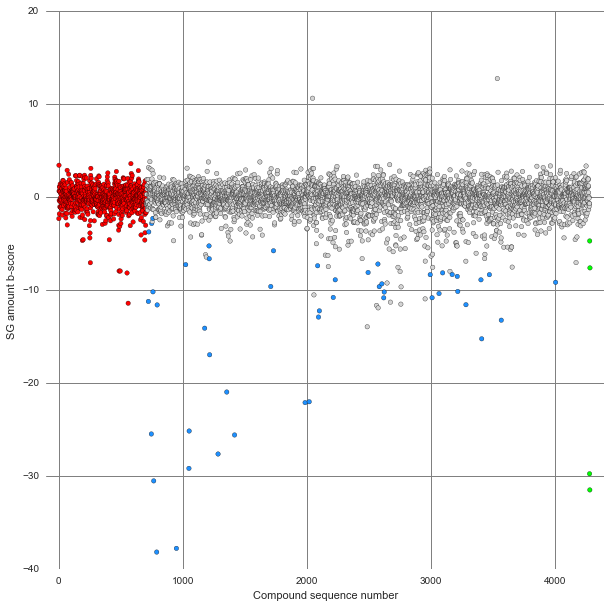

In [364]:
#plt.figure()

#curly braces denote a dictionary/dict
use_colors = {1: 'red', 2: 'lightgrey', 3: 'dodgerblue', 4: 'lime'}


# hek_bscores_reorg.plot(kind = 'scatter', x = 'plotted sequence number', y = 'avg', c = 'color')
ax = hek_bscores_reorg.plot(kind = 'scatter', x = 'Compound sequence number', y = 'SG amount b-score',
                       c = [use_colors[x] for x in hek_bscores_reorg['color']], figsize = (10, 10),
                      xlim = (-100, 4400), ylim = (-40, 20))

#print ax.get_axis_bgcolor()
ax.set_axis_bgcolor('white')

#changes the grid color of all figures in plt.figure()?
plt.grid(color = 'grey')
#shows all figures in plt.figure()?
plt.show()

fig = ax.get_figure()
fig.savefig('{}/293 primary screen reorg fig.png'.format(bscores_hitcoord_folder), facecolor=npc_ax.get_axis_bgcolor(), edgecolor='grey')


In [289]:
#df = pd.DataFrame()
screen_dim = pd.DataFrame()
hit_coord = pd.DataFrame()
pos_coord = pd.DataFrame()
#hit_coord_reduced = pd.DataFrame()
dfs = pd.DataFrame()

for name, df in npc_bscores.groupby(['screen']):
    neg_coord = []
    #print name
    
    #print df
    screen_dim = npc_dim.loc[name]
    #print screen_dim
    screen_dim_np = screen_dim.as_matrix()
    
    #print screen_dim_np
    
    df = isolate_bscores(df, screen_dim_np)
    
    df = reshape_bscores(df, screen_dim_np)
    
    df = add_well_seq_num(df)

    
    hit_coord = npc_hitcoord.loc[name]
    hit_coord = convert_coord(hit_coord, screen_dim_np)
    hit_coord = isolate_well_seq_num(hit_coord, HIT_FLAG)

    pos_coord = npc_poscoord.loc[name]
    #a single row slice of a DataFrame becomes a Series, so need to convert it to a DataFrame, and then make the index labels
    #as the column labels using the transpose() function
    if isinstance(pos_coord, pd.Series):
        pos_coord = pos_coord.to_frame()
        pos_coord = pos_coord.transpose()
    pos_coord = convert_coord(pos_coord, screen_dim_np)
    pos_coord = isolate_well_seq_num(pos_coord, POS_CTRL_FLAG)

    
    df = label_neg_ctrls(name, df, neg_coord, screen_dim_np)
    
    df = label_hits(df, hit_coord)
    
    df = label_pos_ctrls(df, pos_coord)
    
    dfs = dfs.append(df)
    
    #print df
    #df_np = df.as_matrix()
    #df = reshape_array()
    
    #print x

    #dfs = hek_bscores.loc[x + 1]
    #print dfs
    #array_subset = df_subset.as_matrix()

    #reshaped_array_subset = reshape_bscores(array_subset, data_array_dim[0], data_array_dim[1], data_array_dim[2])

    #label_array_subset = 

dfs = dfs.reset_index(drop = True)
dfs_bscores_only = dfs.ix[:, 0:(MAX_NUM_REPL)]
# asdf = pd.DataFrame()
# asdf = dfs_bscores_only.mean(axis = 1, dropna = False)
# asdf
#dfs_bscores_only
dfs['avg'] = dfs_bscores_only.mean(axis = 1, dropna = False)
dfs = dfs.rename(columns = {'avg':'SG amount b-score'})

#dfs
# dfs_hits = dfs.groupby(['hit'])
# dfs_hits

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [290]:
dfs_neg_ctrl = dfs.loc[dfs['neg ctrl'] == 1]
dfs_neg_ctrl['color'] = RED_COLOR
#dfs_neg_ctrl
dfs_pos_ctrl = dfs.loc[dfs['pos ctrl'] == 1]
dfs_pos_ctrl['color'] = GREEN_COLOR
#dfs_pos_ctrl
dfs_cmpds = dfs.loc[dfs['neg ctrl'] != 1]
#dfs_cmpds
dfs_cmpds = dfs_cmpds.loc[dfs_cmpds['pos ctrl'] != 1]
#dfs_cmpds
dfs_cmpds['color'] = BLACK_COLOR
dfs_cmpds.loc[dfs_cmpds['hit'] == 1, 'color'] = BLUE_COLOR

npc_bscores_reorg = pd.DataFrame()
npc_bscores_reorg = npc_bscores_reorg.append(dfs_neg_ctrl)
npc_bscores_reorg = npc_bscores_reorg.append(dfs_cmpds)
npc_bscores_reorg = npc_bscores_reorg.append(dfs_pos_ctrl)

npc_bscores_reorg = npc_bscores_reorg.reset_index(drop = True)
npc_bscores_reorg = npc_bscores_reorg.reset_index(drop = False)
npc_bscores_reorg = npc_bscores_reorg.rename(columns = {'index':'Compound sequence number'})
npc_bscores_reorg['Compound sequence number'] = npc_bscores_reorg['Compound sequence number'] + 1
npc_bscores_reorg

#dfs_cmpds

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Compound sequence number          0          1          2  hit  \
0                            1   1.276160  -0.000491  -3.453218  NaN   
1                            2   1.061302   2.308043   0.089238  NaN   
2                            3   0.792028   2.063312  -0.013502  NaN   
3                            4   2.658151  -0.442172  -3.933463  NaN   
4                            5  -1.864099  -2.632437  -0.778852  NaN   
5                            6   1.701697   2.263820   1.942789  NaN   
6                            7  -0.211323  -0.255420   1.480602  NaN   
7                            8  -0.548416  -1.329351  -4.060709  NaN   
8                            9   0.726682   2.353878  -0.012388  NaN   
9                           10  -0.711160  -0.250153  -2.092741  NaN   
10                          11  -0.553103  -0.022965   0.013502  NaN   
11                          12   0.115867  -0.055239  -2.446830  NaN   
12                          13  -6.659800   0.596752  -0.368055  NaN   
13                          14  -0.035469  -0.858577  -0.024563  NaN   
14                          15   1.170004   1.282987   1.790233  NaN   
15                          16  -2.399456   0.055239   0.928956  NaN   
16                          17  -1.859621  -0.216443  -1.211281  NaN   
17                          18  -3.520862   0.434225  -0.216168  NaN   
18                          19  -3.879044  -0.361743  -0.618336  NaN   
19                          20  -0.399094   0.215406  -0.165629  NaN   
20                          21  -0.724118  -0.766133  -0.335328  NaN   
21                          22   0.035469  -0.494588  -1.002284  NaN   
22                          23   2.016655   1.224874   0.541476  NaN   
23                          24  -2.340759  -1.995370  -1.007104  NaN   
24                          25   0.967185  -0.057329   0.444830  NaN   
25                          26  -5.456026  -0.257383   0.024563  NaN   
26                          27   0.875694  -0.147491   3.036578  NaN   
27                          28  -1.407397   0.431635   2.376690  NaN   
28                          29  -0.153900   0.848524  -0.008938  NaN   
29                          30  -0.569344  -5.172980   1.964925  NaN   
...                        ...        ...        ...        ...  ...   
7326                      7327   0.955019   0.009829        NaN  NaN   
7327                      7328  -2.749006  -5.857112        NaN  NaN   
7328                      7329   1.891689  -1.831095        NaN  NaN   
7329                      7330  -1.038577  -0.065314        NaN  NaN   
7330                      7331  -5.925325  -0.038434        NaN  NaN   
7331                      7332  -1.355685  -0.573542        NaN  NaN   
7332                      7333  -0.164053   0.392924        NaN  NaN   
7333                      7334   1.982725  -0.041553        NaN  NaN   
7334                      7335  -1.599816  -0.268197        NaN  NaN   
7335                      7336  -0.120794  -2.541368        NaN  NaN   
7336                      7337   0.105534  -1.646802        NaN  NaN   
7337                      7338   0.927610   1.674544        NaN  NaN   
7338                      7339   0.502009   0.066870        NaN  NaN   
7339                      7340   2.015549  -0.330865        NaN  NaN   
7340                      7341   0.810017   0.417372        NaN  NaN   
7341                      7342  -0.977432  -0.385575        NaN  NaN   
7342                      7343   0.888161   0.034857        NaN  NaN   
7343                      7344  -0.553160  -2.392853        NaN  NaN   
7344                      7345  -2.346402   0.176820        NaN  NaN   
7345                      7346  -0.641713  -2.072231        NaN  NaN   
7346                      7347  -1.004167   1.043791        NaN  NaN   
7347                      7348   0.284206  -0.156014        NaN  NaN   
7348                      7349  -0.761566   0.045775        NaN  NaN   
7349                      7350   0.829510   1.

#EAEAF2


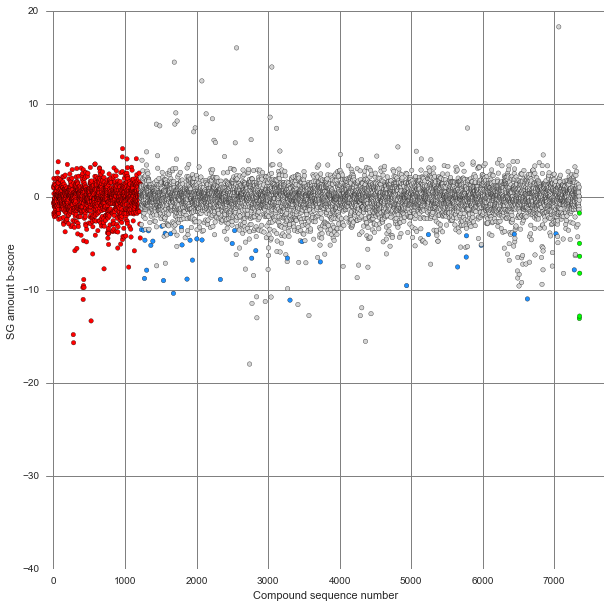

In [365]:
#plt.figure()

#curly braces denote a dictionary/dict
use_colors = {1: 'red', 2: 'lightgrey', 3: 'dodgerblue', 4: 'lime'}

# hek_bscores_reorg.plot(kind = 'scatter', x = 'plotted sequence number', y = 'avg', c = 'color')
ax = npc_bscores_reorg.plot(kind = 'scatter', x = 'Compound sequence number', y = 'SG amount b-score',
                       c = [use_colors[x] for x in npc_bscores_reorg['color']], figsize = (10, 10),
                      xlim = (-100, 7700), ylim = (-40, 20))

#print ax.get_axis_bgcolor()
ax.set_axis_bgcolor('white')
#npc_ax.xaxis.
#npc_ax.set_xticks(np.arange(-100, 7700, 1000, dtype = int))
# npc_ax.spines['top'].set_visible(True)
# npc_ax.spines['bottom'].set_visible(True)
# npc_ax.spines['right'].set_visible(True)
# npc_ax.spines['left'].set_visible(True)

#changes the grid color of all figures in plt.figure()?
plt.grid(color = 'grey')
#shows all figures in plt.figure()?
plt.show()

fig = ax.get_figure()
fig.savefig('{}/npc primary screen reorg fig.png'.format(bscores_hitcoord_folder), facecolor=npc_ax.get_axis_bgcolor(), edgecolor='grey')